This is the core part of my framework I use to test different ideas and features. I didn't include all the code as it would make the competition less exciting. 

In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

from itertools import product

from sklearn.cluster import KMeans

import lightgbm as lgb

In [2]:
dpath  = '../input/competitive-data-science-predict-future-sales/'
adpath ='../input/predict-future-sales/'

In [3]:
# Basic data loading

df_train = pd.read_csv(dpath + 'sales_train.csv')
df_test = pd.read_csv(dpath + 'test.csv', index_col='ID')

df_shops = pd.read_csv(dpath + 'shops.csv', index_col='shop_id')

df_items = pd.read_csv(dpath + 'items.csv', index_col='item_id')
df_itemcat = pd.read_csv(dpath + 'item_categories.csv', index_col='item_category_id')

sample_submission = pd.read_csv(dpath + 'sample_submission.csv', index_col='ID')

In [4]:
# Calendar

calendar = pd.read_csv(adpath + 'calendar.csv', dtype='int16')

In [5]:
# Shops

def shop_name2city(sn):
    sn = sn.split()[0]
    if sn == 'Цифровой' or sn == 'Интернет-магазин': sn = 'Internet'
    if sn[0] == '!': sn = sn[1:]  
    return sn

df_shops['city'] = df_shops['shop_name'].apply(shop_name2city)
df_shops['city_enc'] = LabelEncoder().fit_transform(df_shops['city']).astype('int8')

city_info = pd.read_pickle(adpath + 'city_info.pkl')

df_shops['city_size'] = df_shops['city'].map(city_info['city_size'])

In [6]:
# Define items class

class Items():

    def __init__(self, df_items, df_itemcat):
        
        self.df_items    = df_items
        self.df_itemcat  = df_itemcat
        
        self.set_hl_cat()
        self.make_items_ext()
        
        self.item_features = ['item_category_id', 'hl_cat_id']

    def set_hl_cat(self):
        
        self.df_itemcat['hl_cat_id'] = self.df_itemcat['item_category_name'].str.split(n=1, expand=True)[0]
        self.df_itemcat['hl_cat_id'] = LabelEncoder().fit_transform(self.df_itemcat['hl_cat_id'])
        
    def make_items_ext(self):
    
        self.df_items = df_items.merge(self.df_itemcat, how = 'left', 
                                       left_on = 'item_category_id', right_index = True)

    def get_items_df(self):
        
        return self.df_items[self.item_features].astype('int32')

In [7]:
items = Items(df_items, df_itemcat)

In [8]:
# Define train-test class

class TT_Extended():
    
    def __init__(self, df_train, df_test, items, df_shops, calendar, cmode, verbose=True):
        
        self.info = verbose
        
        self.df_train  = df_train.copy()
        self.df_test   = df_test.copy()
        self.df_shops  = df_shops.copy()
        self.calendar  = self.set_calender(calendar.copy())
        
        self.idx_columns = ['date_block_num', 'shop_id', 'item_id']
        
        self.df_test['date_block_num'] = 34
        self.df_test['item_cnt_month'] = 0.
        self.df_test['item_cnt_month'] = self.df_test['item_cnt_month'].astype('float32')
        
        self.df_train[self.idx_columns] = self.df_train[self.idx_columns].astype('int32')
        self.df_test[self.idx_columns]  = self.df_test[self.idx_columns].astype('int32')
        
        self.df_train_cleaning(cmode)
        
        self.item_mean_features = []
        self.shop_mean_features = []
        self.lag_names_to_clip  = []
        
        self.df_items = items.get_items_df()
        self.item_ext_features = list(self.df_items.columns)
        self.df_items_ext = self.items_ext()
        
        self.df_bb = self.build_bb()
        
        # Critical point: 0 or None
        self.df_train_ext = self.df_train_agg(cmin = 0, cmax = 1000, drop = None)
        
        self.add_test_df()
        
        self.df_train_ext = self.df_train_extention()
        
    def df_train_cleaning(self, mode):
        
        assert mode in ['keep', 'drop', 'block', 'total', 't+b']
        
        # 'keep'  - do nothing
        # 'drop'  - drop all negative rows
        # 'block' - remove item_id if its sum is negative in a block
        # 'total' - remove item_id if its total sum is negative
        # 't+b'   - 'total' + 'block'
        
        if self.info: print('Cleaning train dataframe... ( Mode -', mode, ')')
         
        # Remove very noisy shops 
        
        shop_idx = self.df_train[(self.df_train['shop_id'] == 9)  | 
                                 (self.df_train['shop_id'] == 20)].index
        self.df_train.drop(shop_idx, inplace=True)
        
        
        self.df_train = self.df_train[(self.df_train['item_price'] > 0) & 
                                      (self.df_train['item_price'] < 51000)]
        self.df_train = self.df_train[self.df_train['item_cnt_day'] <= 1000]

        shop_repl_dict = {0 : 57, 1 : 58, 11 : 10, 40 : 39}
    
        self.df_train['shop_id'] = self.df_train['shop_id'].apply(
                                   lambda s: shop_repl_dict.get(s) if s in shop_repl_dict else s)    
            
            
        if   mode == 'drop':
            self.df_train = self.df_train[self.df_train['item_cnt_day'] > 0]
            
        elif mode == 'block':
            item_block_cnt = self.df_train.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum()
            items_to_drop = item_block_cnt[item_block_cnt <= 0].index
            self.df_train = self.df_train[~self.df_train.set_index(
                                            ['date_block_num', 'shop_id', 'item_id']).index.isin(items_to_drop)]
        elif mode == 'total':
            item_total_cnt = self.df_train.groupby(['shop_id', 'item_id'])['item_cnt_day'].sum()
            items_to_drop = item_total_cnt[item_total_cnt <= 0].index
            self.df_train = self.df_train[~self.df_train.set_index(
                                            ['shop_id', 'item_id']).index.isin(items_to_drop)]
            
        elif mode == 't+b':
            item_total_cnt = self.df_train.groupby(['shop_id', 'item_id'])['item_cnt_day'].sum()
            items_to_drop = item_total_cnt[item_total_cnt <= 0].index
            self.df_train = self.df_train[~self.df_train.set_index(
                                            ['shop_id', 'item_id']).index.isin(items_to_drop)]
            
            item_block_cnt = self.df_train.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum()
            items_to_drop = item_block_cnt[item_block_cnt <= 0].index
            self.df_train = self.df_train[~self.df_train.set_index(
                                            ['date_block_num', 'shop_id', 'item_id']).index.isin(items_to_drop)]
            
            
        return
        
    def set_calender(self, calendar):
        
        calendar['date_block_num'] = (calendar['year'] - 2013)*12 + (calendar['month'] - 1)
        calendar['hdays'] = calendar['mdays'] - calendar['wdays']
        calendar.set_index('date_block_num', inplace=True)
        
        return calendar
    
    def items_ext(self):
        
        dfi = self.df_items.copy()
        
        dfi['fsb'] = self.df_train.groupby('item_id')['date_block_num'].min()
        
        dfi['fsb'].fillna(34, inplace=True)
        dfi['fsb'] = dfi['fsb'].astype('int8')
        
        self.item_ext_features += ['fsb']
        
        return dfi
    
    def build_bb(self):
        
        if self.info: print('Building index dataframe...')

        df_work = []

        for block_num in self.df_train['date_block_num'].unique():
    
            cur_shops = self.df_train.loc[self.df_train['date_block_num'] == block_num, 'shop_id'].unique()
            cur_items = self.df_train.loc[self.df_train['date_block_num'] == block_num, 'item_id'].unique()
    
            df_work.append(np.array(list(product(*[[block_num], cur_shops, cur_items])), dtype='int32'))

        df_work = pd.DataFrame(np.vstack(df_work), columns = self.idx_columns)
            
        return df_work
    
    def df_train_agg(self, cmin = 0, cmax = 20, drop = None):
        
        if self.info: print('Aggregation...')
        
        df_work = self.df_train.groupby(self.idx_columns).agg({'item_price'  : np.mean, 
                                                               'item_cnt_day': np.sum})
        df_work.reset_index(inplace=True)
        df_work = df_work.rename(columns={'item_cnt_day': 'item_cnt_month'})
        
        df_work = pd.merge(self.df_bb, df_work, on=self.idx_columns, how='left')
        
        df_work['item_cnt_month'] = df_work['item_cnt_month'].astype('float32').fillna(0.).clip(cmin, cmax)
        df_work['item_price'] = df_work['item_price'].astype('float32').fillna(0.)
        
        df_tmp = self.df_train[self.df_train['item_cnt_day'] > 0].groupby(self.idx_columns).agg({'item_cnt_day': 'count'})
        df_tmp.reset_index(inplace=True)
        df_tmp = df_tmp.rename(columns={'item_cnt_day': 'item_rate_month'})
        
        df_work = pd.merge(df_work, df_tmp, on=self.idx_columns, how='left')
        
        df_work['item_rate_month'] = df_work['item_rate_month'].astype('float32').fillna(0.)
        
        del df_tmp
        
        if drop: df_work.drop(drop, axis=1, inplace=True)
        
        return df_work
    
    def add_test_df(self):
        
        self.df_train_ext = pd.concat([self.df_train_ext, self.df_test], ignore_index=True,
                                      sort=False, keys=self.idx_columns)
    
    def add_item_means(self, df, feature = None):
        
        # Adding item means
        
        if feature == None :
            group_items = ['date_block_num','item_id']
            feature = 'item_cnt'
        else:
            group_items = ['date_block_num','item_id'] + [feature]
            
        feature_mean_name = feature + '_mean'
            
        if self.info: print('Adding item means for', feature, '...')
        
        df_tmp = df.groupby(group_items)['item_cnt_month'].mean()
        df_tmp = df_tmp.reset_index().rename(columns = {'item_cnt_month': feature_mean_name})
        
        df = pd.merge(df, df_tmp, on=group_items, how='left')
        
        self.item_mean_features.append(feature_mean_name)
        
        del df_tmp
        
        return df
    
    def add_shop_means(self, df, feature):
        
        # Adding shop means
        
        group_items = ['date_block_num', 'shop_id'] + [feature]
            
        feature_mean_name = feature + '_mean'
            
        if self.info: print('Adding shop means for', feature, '...')
        
        df_tmp = df.groupby(group_items)['item_cnt_month'].mean()
        df_tmp = df_tmp.reset_index().rename(columns = {'item_cnt_month': feature_mean_name})
        
        df = pd.merge(df, df_tmp, on=group_items, how='left')
        
        self.shop_mean_features.append(feature)
        
        del df_tmp
        
        return df
        
    
    def df_train_extention(self, test_cat_only = False):
        
        df_work = self.df_train_ext.merge(df_shops[['city_enc', 'city_size']], how = 'left', on = 'shop_id')
        
        df_work = df_work.merge(self.calendar[['mdays', 'wdays', 'hdays']], 
                                how = 'left', left_on = 'date_block_num', right_index = True)
        
        df_work = df_work.merge(self.df_items_ext[self.item_ext_features],
                                how = 'left', left_on = 'item_id', right_index = True)
        
        # Shop start block number
        
        ssbn = self.df_train.groupby('shop_id')['date_block_num'].min().astype('int8')
        ssbn.name = 'ssbn'
        df_work = df_work.merge(ssbn, how = 'left', on = 'shop_id')
        
        if test_cat_only:
            test_cat = df_work[df_work['date_block_num'] == 34]['item_category_id'].unique()
            df_work = df_work[df_work['item_category_id'].isin(test_cat)]

        return df_work
    
    def make_base_df(self, keepnans = False):
        
        # Make base dataframe
        
        df_work = self.df_train_ext.copy()
        
        if keepnans:
            fill_value = None
        else:
            fill_value = 0    
            
        df_work = pd.pivot_table(df_work, values='item_cnt_month', index=['shop_id', 'item_id'], 
                                     columns = 'date_block_num', aggfunc=np.sum, fill_value = fill_value)
        df_work.columns.name = ''
        
        return df_work
    
    def add_total_cnt(self, df):
        
        if self.info: print('Adding total count...')
        
        df_base = self.make_base_df()
        
        for i in range(1, 33):
            df_base[i + 1] += df_base[i]
            
        df_base = df_base.shift(1, axis=1).loc[:, 1:].astype('int32')
        df_base = df_base.melt(var_name='date_block_num', value_name='total_cnt', ignore_index=False)
        
        df = df.merge(df_base, how='left', on=self.idx_columns)
        
        del df_base
        
        return df
    
    def add_item_lags(self, df, feature_name, nlags=3, keepnans=False, dnc=False):
        
        if self.info: print('Adding item lags for', feature_name, '...')
    
        df_tmp = df[['date_block_num', 'shop_id', 'item_id', feature_name]]
    
        for i in range(nlags, 0, -1):
        
            lag_feature_name = feature_name +'_lag-' + str(i)
            if not dnc: self.lag_names_to_clip.append(lag_feature_name)
        
            df_shifted = df_tmp.copy()
            df_shifted.columns = ['date_block_num', 'shop_id', 'item_id', lag_feature_name]
            df_shifted['date_block_num'] += i
            df = pd.merge(df, df_shifted, on=['date_block_num', 'shop_id', 'item_id'], how='left')
            
            if keepnans:
                df[lag_feature_name] = df[lag_feature_name].astype('float32')
            else:
                df[lag_feature_name] = df[lag_feature_name].fillna(0).astype('float32')
        
        del df_tmp
    
        return df
    
    def add_shop_lags(self, df, feature_name, nlags=3, dnc=False):
        
        mean_feature_name = feature_name + '_mean'
        
        if self.info: print('Adding lags for', mean_feature_name, '...')
    
        df_tmp = df[['date_block_num', 'shop_id', feature_name, mean_feature_name]]
    
        for i in range(nlags, 0, -1):
        
            lag_feature_name = mean_feature_name + '_lag-' + str(i)
            if not dnc: self.lag_names_to_clip.append(lag_feature_name)
        
            df_shifted = df_tmp.copy()
            df_shifted.columns = ['date_block_num', 'shop_id', feature_name, lag_feature_name]
            df_shifted['date_block_num'] += i
            df = pd.merge(df, df_shifted.drop_duplicates(), on=['date_block_num', 'shop_id', feature_name], how='left')
            df[lag_feature_name] = df[lag_feature_name].fillna(0).astype('float32')
        
        del df_tmp
        del df_shifted
    
        return df
    
    def shop_clustering(self, df_work):
        
        # Clustering algorithm can be defined at run time
        
        print('No shop clusters provided')
        
        return df_work
    
    def build_work_db(self, hd, item_mean_features = [], shop_mean_features = [], add_total_cnt = False):
        
        if self.info: print('Building work dataframe...')
        
        df_work = self.df_train_ext.copy()
        
        df_work = self.add_item_means(df_work)
        
        for mf in item_mean_features:
            
            df_work = self.add_item_means(df_work, mf)
            
        for mf in shop_mean_features:
            
            df_work = self.add_shop_means(df_work, mf)
        
        # Critical point: True or False (Affects qmean calculation)
        df_work = self.add_item_lags(df_work, 'item_cnt_month', hd, keepnans=False)
        df_work = self.add_item_lags(df_work, 'item_rate_month', hd, dnc=True)
        df_work = self.add_item_lags(df_work, 'item_price', hd, dnc=True)
            
        for mf in self.item_mean_features:
            
            df_work = self.add_item_lags(df_work, mf, hd)
            
        for mf in self.shop_mean_features:
            
            df_work = self.add_shop_lags(df_work, mf, hd)
        
        df_work.drop(df_work[df_work['date_block_num'] < hd].index, inplace=True)
        
        df_work.drop(self.item_mean_features, axis=1, inplace=True)
        df_work.drop(['item_category_id_mean', 'item_price', 'item_rate_month'], axis=1, inplace=True)
        
        self.item_mean_features = []
        self.shop_mean_features = []
        
    
        df_work['qmean'] = df_work[['item_cnt_month_lag-1', 
                                    'item_cnt_month_lag-2', 
                                    'item_cnt_month_lag-3']].mean(skipna=True, axis=1)
        
        df_work['new'] = df_work['fsb'] ==  df_work['date_block_num']
        
        df_work['fsb'] = df_work['date_block_num'] - df_work['fsb']
        df_work['ssbn'] = df_work['date_block_num'] - df_work['ssbn']
        
        df_work['month'] = (df_work['date_block_num']%12).astype('int8')
        
        
        idx = df_work[(df_work['item_price_lag-1'] == 0) & (df_work['item_price_lag-2'] != 0)].index
        df_work.loc[idx, 'item_price_lag-1'] = df_work.loc[idx, 'item_price_lag-2']
        idx = df_work[(df_work['item_price_lag-2'] == 0) & (df_work['item_price_lag-3'] != 0)].index
        df_work.loc[idx, 'item_price_lag-2'] = df_work.loc[idx, 'item_price_lag-3']
        
        df_work['grad-1'] = df_work['item_cnt_month_lag-1']/df_work['item_cnt_month_lag-2']
        df_work['grad-1'] = df_work['grad-1'].replace([np.inf, -np.inf], np.nan).fillna(0.)

        df_work['grad-2'] = df_work['item_cnt_month_lag-2']/df_work['item_cnt_month_lag-3']
        df_work['grad-2'] = df_work['grad-2'].replace([np.inf, -np.inf], np.nan).fillna(0.)
        
        # Shop clustering
        
        df_work = self.shop_clustering(df_work)
        
        # Moving total
        
        if add_total_cnt: df_work = self.add_total_cnt(df_work)
            
        # Clipping    
  
        col2clip = ['item_cnt_month', 'qmean'] + self.lag_names_to_clip
        df_work[col2clip] = df_work[col2clip].clip(0, 20)
        
        return df_work
    
    def get_work_db(self, hd = 3, item_mean_features = [], 
                                  shop_mean_features = [], 
                                  drop_features = None,
                                  add_total_cnt = False):
        
        df_work = self.build_work_db(hd, item_mean_features, shop_mean_features, add_total_cnt)

        if drop_features == None:
            return df_work
        else:
            return df_work.drop(drop_features, axis = 1)

In [9]:
%%time

pfs = TT_Extended(df_train, df_test, items, df_shops, calendar, cmode='total')

Cleaning train dataframe... ( Mode - total )
Building index dataframe...
Aggregation...
CPU times: user 40 s, sys: 5.83 s, total: 45.8 s
Wall time: 45.6 s


In [10]:
pfs.df_train_ext.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10987637 entries, 0 to 10987636
Data columns (total 15 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date_block_num    int32  
 1   shop_id           int32  
 2   item_id           int32  
 3   item_price        float32
 4   item_cnt_month    float32
 5   item_rate_month   float32
 6   city_enc          int8   
 7   city_size         float32
 8   mdays             int16  
 9   wdays             int16  
 10  hdays             int16  
 11  item_category_id  int32  
 12  hl_cat_id         int32  
 13  fsb               int8   
 14  ssbn              int8   
dtypes: float32(4), int16(3), int32(5), int8(3)
memory usage: 555.4 MB


In [11]:
#-----------------------------------------------------

In [12]:
# Define shop clustering methods

def simple_shop_clustering(df_work):
    
    noisy_shops = [25, 31, 42]
    df_work['shop_group'] = df_work['shop_id'].isin(noisy_shops)
    
    return df_work

def knn_shop_clustering(df_work):
    
    df_sg = pd.pivot_table(df_work[df_work['item_cnt_month'] != 0], 
                           values='item_cnt_month', index=['shop_id'], 
                           columns = 'date_block_num', aggfunc='count', fill_value = 0)
    
    kmeans = KMeans(n_clusters=6, random_state=0).fit(df_sg)
    df_sg['shop_group'] = kmeans.labels_.astype('int8')
    df_work['shop_group'] = df_work['shop_id'].map(df_sg['shop_group'])
    
    del df_sg
    
    assert list(df_work[df_work['shop_group'].isna()]['shop_id'].unique()) == [], 'Missing shop found'
    
    return df_work

In [13]:
pfs.shop_clustering = simple_shop_clustering

In [14]:
%%time

df_work = pfs.get_work_db(hd = 3, 
                          item_mean_features = ['city_enc'], 
                          shop_mean_features = ['item_category_id'], 
                          drop_features = ['wdays', 'hdays', 'ssbn'],
                          add_total_cnt = False).copy()

Building work dataframe...
Adding item means for item_cnt ...
Adding item means for city_enc ...
Adding shop means for item_category_id ...
Adding item lags for item_cnt_month ...
Adding item lags for item_rate_month ...
Adding item lags for item_price ...
Adding item lags for item_cnt_mean ...
Adding item lags for city_enc_mean ...
Adding lags for item_category_id_mean ...
CPU times: user 2min 13s, sys: 43.6 s, total: 2min 56s
Wall time: 2min 55s


In [15]:
df_work.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9866074 entries, 1121563 to 10987636
Data columns (total 34 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   date_block_num               int32  
 1   shop_id                      int32  
 2   item_id                      int32  
 3   item_cnt_month               float32
 4   city_enc                     int8   
 5   city_size                    float32
 6   mdays                        int16  
 7   item_category_id             int32  
 8   hl_cat_id                    int32  
 9   fsb                          int32  
 10  item_cnt_month_lag-3         float32
 11  item_cnt_month_lag-2         float32
 12  item_cnt_month_lag-1         float32
 13  item_rate_month_lag-3        float32
 14  item_rate_month_lag-2        float32
 15  item_rate_month_lag-1        float32
 16  item_price_lag-3             float32
 17  item_price_lag-2             float32
 18  item_price_lag-1             float3

In [16]:
#-----------------------------------------------------

In [17]:
# New features to test

In [18]:
df_work['city_size'] = df_work['city_size'].round(1) # less noisy

In [19]:
#-----------------------------------------------------

In [20]:
# Train

In [21]:
X_train = df_work[df_work.date_block_num < 33].drop(['item_cnt_month'], axis=1)
y_train = df_work[df_work.date_block_num < 33]['item_cnt_month']
X_valid = df_work[df_work.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_valid = df_work[df_work.date_block_num == 33]['item_cnt_month']
X_test = df_work[df_work.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [22]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9430114 entries, 1121563 to 10551676
Data columns (total 33 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   date_block_num               int32  
 1   shop_id                      int32  
 2   item_id                      int32  
 3   city_enc                     int8   
 4   city_size                    float32
 5   mdays                        int16  
 6   item_category_id             int32  
 7   hl_cat_id                    int32  
 8   fsb                          int32  
 9   item_cnt_month_lag-3         float32
 10  item_cnt_month_lag-2         float32
 11  item_cnt_month_lag-1         float32
 12  item_rate_month_lag-3        float32
 13  item_rate_month_lag-2        float32
 14  item_rate_month_lag-1        float32
 15  item_price_lag-3             float32
 16  item_price_lag-2             float32
 17  item_price_lag-1             float32
 18  item_cnt_mean_lag-3          float3

In [23]:
# This cell was added to deal with Kaggle VM memory limitation
del df_work

In [24]:
%%time

feature_names = X_train.columns.tolist()

params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 255,
    'learning_rate': 0.005,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1,
    'force_row_wise' : True
}

categorical_feature_names = [ 
                            'item_category_id',
                            'hl_cat_id', 
                            'city_enc',
                            'month',
                            'shop_group',
                            'shop_id'
                            ]

lgb_train = lgb.Dataset(X_train[feature_names], y_train, categorical_feature=None)
lgb_eval  = lgb.Dataset(X_valid[feature_names], y_valid, categorical_feature=None, reference=lgb_train)

evals_result = {}
gbm = lgb.train(
        params, 
        lgb_train,
        num_boost_round = 4000,
        valid_sets = (lgb_train, lgb_eval), 
        feature_name = feature_names,
        categorical_feature = categorical_feature_names,
        verbose_eval = 100, 
        evals_result = evals_result,
        early_stopping_rounds = 100)

[LightGBM] [Info] Total Bins 3967
[LightGBM] [Info] Number of data points in the train set: 9430114, number of used features: 33


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 0.296639
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.00433	valid_1's rmse: 0.911484
[200]	training's rmse: 0.902266	valid_1's rmse: 0.838853
[300]	training's rmse: 0.850198	valid_1's rmse: 0.808265
[400]	training's rmse: 0.821583	valid_1's rmse: 0.796057
[500]	training's rmse: 0.803492	valid_1's rmse: 0.791116
[600]	training's rmse: 0.790448	valid_1's rmse: 0.789039
[700]	training's rmse: 0.780148	valid_1's rmse: 0.788376
[800]	training's rmse: 0.772003	valid_1's rmse: 0.787741
[900]	training's rmse: 0.76568	valid_1's rmse: 0.787434
[1000]	training's rmse: 0.760004	valid_1's rmse: 0.786989
[1100]	training's rmse: 0.75508	valid_1's rmse: 0.786574
[1200]	training's rmse: 0.750844	valid_1's rmse: 0.786459
[1300]	training's rmse: 0.747109	valid_1's rmse: 0.786371
[1400]	training's rmse: 0.743757	valid_1's rmse: 0.78627
[1500]	training's rmse: 0.74082	valid_1's rmse: 0.786018
[1600]	training's rmse: 0.738

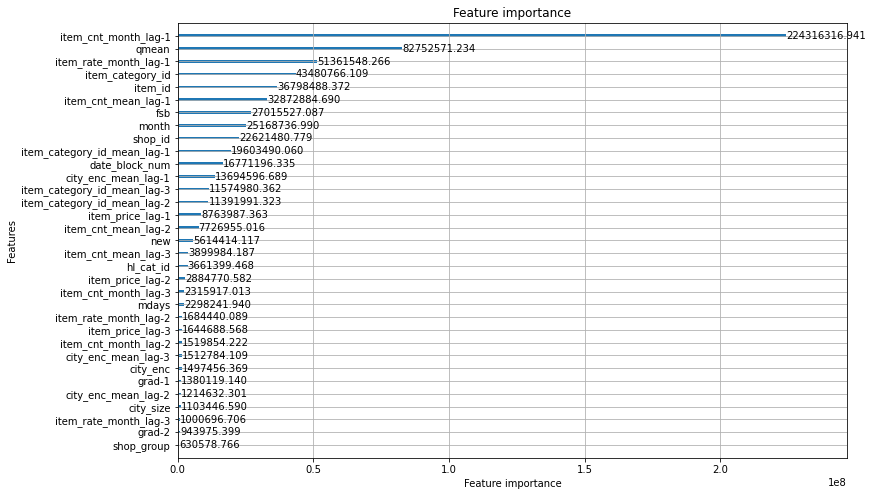

In [25]:
lgb.plot_importance(
    gbm, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(12,8));

In [26]:
sample_submission['item_cnt_month'] = gbm.predict(X_test[feature_names]).clip(0, 20)
sample_submission.to_csv('submission_k4.csv')